Download the california data

### Reference from the below link

https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=firststeps-colab&hl=en#scrollTo=ci1ISxxrZ7v0

In [0]:
import sklearn.datasets
from sklearn import metrics

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR)

import math
import matplotlib.pyplot as plt
from matplotlib import cm

from IPython import display

In [0]:
cal_housing = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

Randomize the data

In [0]:
cal_housing = cal_housing.reindex(np.random.permutation(cal_housing.index))

In [33]:
cal_housing.head()

longitude  latitude  ...  median_income  median_house_value
1231     -117.14     33.94  ...         6.3223            223200.0
8103     -118.43     34.28  ...         2.3724            154200.0
13149    -121.89     37.45  ...         4.7500            254400.0
8129     -118.43     34.17  ...         4.4464            353100.0
640      -117.04     34.02  ...         1.4418            103500.0

[5 rows x 9 columns]

In [34]:
cal_housing.describe()

longitude      latitude  ...  median_income  median_house_value
count  17000.000000  17000.000000  ...   17000.000000        17000.000000
mean    -119.562108     35.625225  ...       3.883578       207300.912353
std        2.005166      2.137340  ...       1.908157       115983.764387
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.790000     33.930000  ...       2.566375       119400.000000
50%     -118.490000     34.250000  ...       3.544600       180400.000000
75%     -118.000000     37.720000  ...       4.767000       265000.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

Additionally, we'll scale median_house_value to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [0]:
cal_housing['median_house_value'] /= 1000.0

In [36]:
cal_housing.head()

longitude  latitude  ...  median_income  median_house_value
1231     -117.14     33.94  ...         6.3223               223.2
8103     -118.43     34.28  ...         2.3724               154.2
13149    -121.89     37.45  ...         4.7500               254.4
8129     -118.43     34.17  ...         4.4464               353.1
640      -117.04     34.02  ...         1.4418               103.5

[5 rows x 9 columns]

In [37]:
cal_housing.describe()

longitude      latitude  ...  median_income  median_house_value
count  17000.000000  17000.000000  ...   17000.000000        17000.000000
mean    -119.562108     35.625225  ...       3.883578          207.300912
std        2.005166      2.137340  ...       1.908157          115.983764
min     -124.350000     32.540000  ...       0.499900           14.999000
25%     -121.790000     33.930000  ...       2.566375          119.400000
50%     -118.490000     34.250000  ...       3.544600          180.400000
75%     -118.000000     37.720000  ...       4.767000          265.000000
max     -114.310000     41.950000  ...      15.000100          500.001000

[8 rows x 9 columns]

To start, we're going to use just one numeric input feature, total_rooms. The following code pulls the total_rooms data from our california_housing_dataframe and defines the feature column using numeric_column, which specifies its data is numeric:

In [0]:
#define input feature total rooms
my_feature = cal_housing[['total_rooms']]

#configure a numeric feature columns for total_rooms
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

In [0]:
#define the target
targets = cal_housing['median_house_value']

### Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the GradientDescentOptimizer, which implements Mini-Batch Stochastic Gradient Descent (SGD). The learning_rate argument controls the size of the gradient step


In [0]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer = my_optimizer
)

### Define the Input Function

To import our California housing data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow how to preprocess
the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our *pandas* feature data into a dict of NumPy arrays. We can then use the TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) to construct a dataset object from our data, and then break
our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 

**NOTE:** When the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitely.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies
the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  #convert pandas data into dict of np arrays
  features = {key:np.array(value) for key, value in dict(features).items()}

  #construct a dataset and configure batching/repeating
  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)

  if shuffle:
    ds = ds.shuffle(buffer_size=10000)

  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels


### Train the Model

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

### Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

NOTE: Training error measures how well your model fits the training data, but it does not measure how well your model generalizes to new data. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.

In [43]:
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

predictions = linear_regressor.predict(input_fn=prediction_input_fn)

predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


In [44]:
min_house_value = cal_housing["median_house_value"].min()
max_house_value = cal_housing["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [45]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

predictions       targets
count  17000.000000  17000.000000
mean       0.132184    207.300912
std        0.108997    115.983764
min        0.000100     14.999000
25%        0.073100    119.400000
50%        0.106350    180.400000
75%        0.157563    265.000000
max        1.896850    500.001000

In [0]:
sample = cal_housing.sample(n=300)

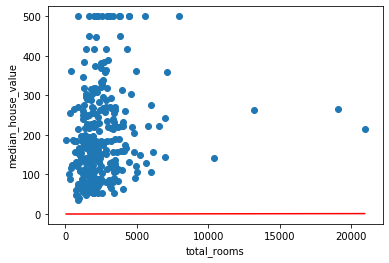

In [47]:
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

y_0 = weight*x_0 + bias
y_1 = weight*x_1+bias

plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

plt.scatter(sample['total_rooms'], sample['median_house_value'])

plt.show()


### Tweak the Model hyperparameters


In [0]:
def train_model(learning_rate, steps, batch_size, input_feature = "total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  periods=10
  steps_per_period = steps/periods

  my_feature = input_feature
  my_feature_data = cal_housing[[my_feature]]
  my_label = "median_house_value"
  targets = cal_housing[my_label]

  #create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]

  #create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)

  #create a linear regression object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  #Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1,2,1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = cal_housing.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  #Train the model, but do so inside a loop so that we can periodically assess
  #loss metrics
  print("Training model...")
  print("RSME on training data:")
  root_mean_squared_errors = []
  for period in range(0, periods):
    #train the model starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )

    #Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])

    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

  return calibration_data

Training model...
RSME on training data:
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90
  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


predictions       targets
count  17000.000000  17000.000000
mean      13.218373    207.300912
std       10.899719    115.983764
min        0.010003     14.999000
25%        7.309996    119.400000
50%       10.634993    180.400000
75%       15.756238    265.000000
max      189.684814    500.001000

Final RMSE (on training data): 225.63


predictions  targets
0        24.364981     66.9
1         4.309999     80.1
2        12.139991     85.7
3        10.899993     73.4
4        23.314981     65.5
...            ...      ...
16995    19.369986    111.4
16996    10.494993     79.0
16997    17.654987    103.6
16998    12.174992     85.8
16999    19.789986     94.6

[17000 rows x 2 columns]

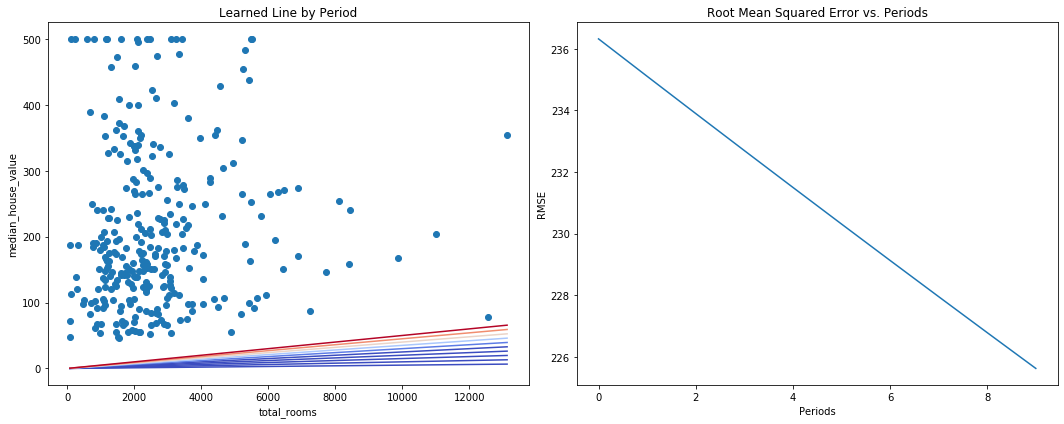

In [49]:
train_model(
    learning_rate=0.00001, 
    steps=100,
    batch_size=1
)

Training model...
RSME on training data:
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 195.33
  period 04 : 187.86
  period 05 : 180.53
  period 06 : 175.00
  period 07 : 171.40
  period 08 : 168.61
  period 09 : 167.09
Model training finished.


predictions       targets
count  17000.000000  17000.000000
mean     118.436241    207.300912
std       97.661743    115.983764
min        0.089636     14.999000
25%       65.497711    119.400000
50%       95.289749    180.400000
75%      141.176193    265.000000
max     1699.579468    500.001000

Final RMSE (on training data): 167.09


predictions  targets
0       218.310684     66.9
1        38.617680     80.1
2       108.774559     85.7
3        97.664146     73.4
4       208.902664     65.5
...            ...      ...
16995   173.555420    111.4
16996    94.035347     79.0
16997   158.189011    103.6
16998   109.088158     85.8
16999   177.318634     94.6

[17000 rows x 2 columns]

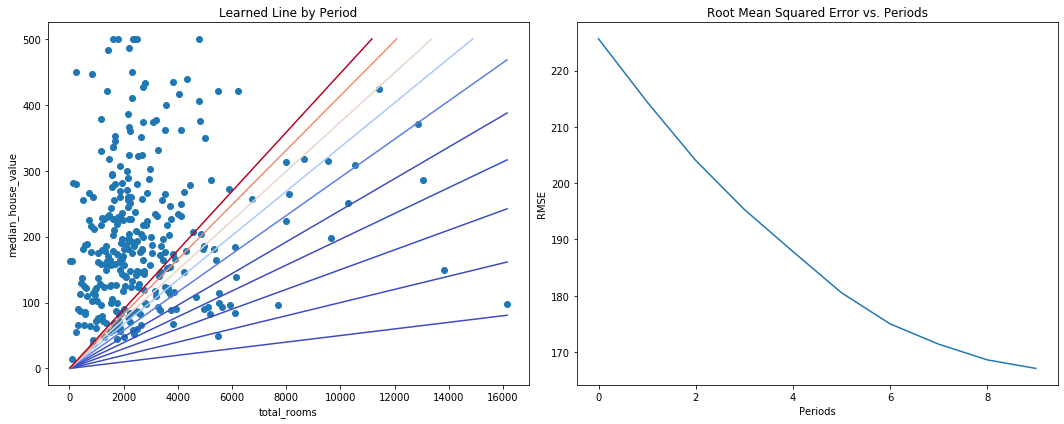

In [50]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

### Is There a Standard Heuristic for Model Tuning?

This is a commonly asked question. The short answer is that the effects of different hyperparameters are data dependent. So there are no hard-and-fast rules; you'll need to test on your data.

That said, here are a few rules of thumb that may help guide you:

 * Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
 * If the training has not converged, try running it for longer.
 * If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
   * But sometimes the exact opposite may happen if the learning rate is too high.
 * If the training error varies wildly, try decreasing the learning rate.
   * Lower learning rate plus larger number of steps or larger batch size is often a good combination.
 * Very small batch sizes can also cause instability.  First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data dependent.  Always experiment and verify.

## Task 2: Try a Different Feature

See if you can do any better by replacing the `total_rooms` feature with the `population` feature.

Don't take more than 5 minutes on this portion.


Training model...
RSME on training data:
  period 00 : 225.63
  period 01 : 214.84
  period 02 : 205.05
  period 03 : 196.42
  period 04 : 189.66
  period 05 : 184.35
  period 06 : 180.42
  period 07 : 178.01
  period 08 : 176.70
  period 09 : 176.14
Model training finished.


predictions       targets
count  17000.000000  17000.000000
mean     117.514969    207.300912
std       94.356529    115.983764
min        0.246786     14.999000
25%       64.940300    119.400000
50%       95.930710    180.400000
75%      141.471008    265.000000
max     2933.156494    500.001000

Final RMSE (on training data): 176.14


predictions  targets
0       160.048813     66.9
1       102.178116     80.1
2       138.676117     85.7
3        74.475807     73.4
4       152.157364     65.5
...            ...      ...
16995   200.656937    111.4
16996    71.763123     79.0
16997   123.715218    103.6
16998    89.436699     85.8
16999   201.889984     94.6

[17000 rows x 2 columns]

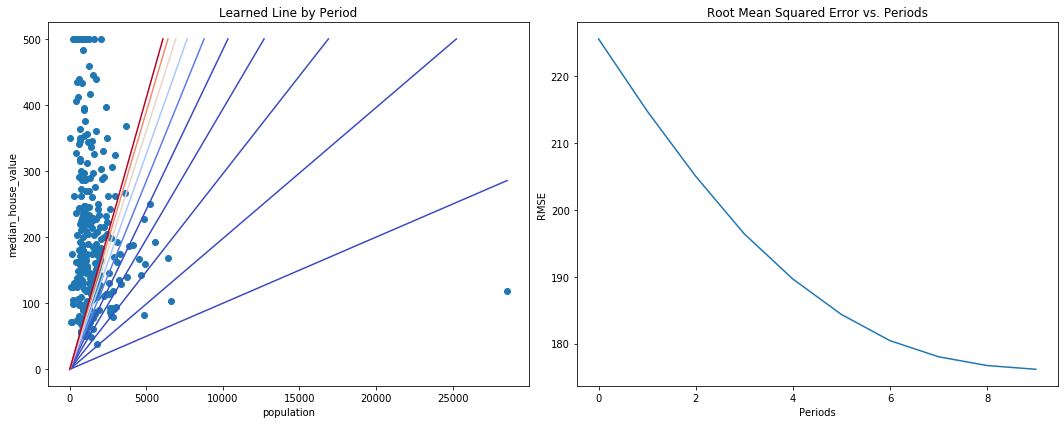

In [51]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=10,
    input_feature='population'
)

### https://colab.research.google.com/notebooks/mlcc/synthetic_features_and_outliers.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=syntheticfeatures-colab&hl=en#scrollTo=5ihcVutnnu1D

## Task 1: Try a Synthetic Feature

Both the `total_rooms` and `population` features count totals for a given city block.

But what if one city block were more densely populated than another? We can explore how block density relates to median house value by creating a synthetic feature that's a ratio of `total_rooms` and `population`.

In the cell below, create a feature called `rooms_per_person`, and use that as the `input_feature` to `train_model()`.

What's the best performance you can get with this single feature by tweaking the learning rate? (The better the performance, the better your regression line should fit the data, and the lower
the final RMSE should be.)

Training model...
RSME on training data:
  period 00 : 212.73
  period 01 : 189.66
  period 02 : 168.95
  period 03 : 152.31
  period 04 : 140.56
  period 05 : 133.55
  period 06 : 131.26
  period 07 : 130.85
  period 08 : 131.61
  period 09 : 131.77
Model training finished.


predictions       targets
count  17000.000000  17000.000000
mean     196.501556    207.300912
std       90.129440    115.983764
min       45.186939     14.999000
25%      161.119808    119.400000
50%      193.441628    180.400000
75%      220.927105    265.000000
max     4300.762695    500.001000

Final RMSE (on training data): 131.77


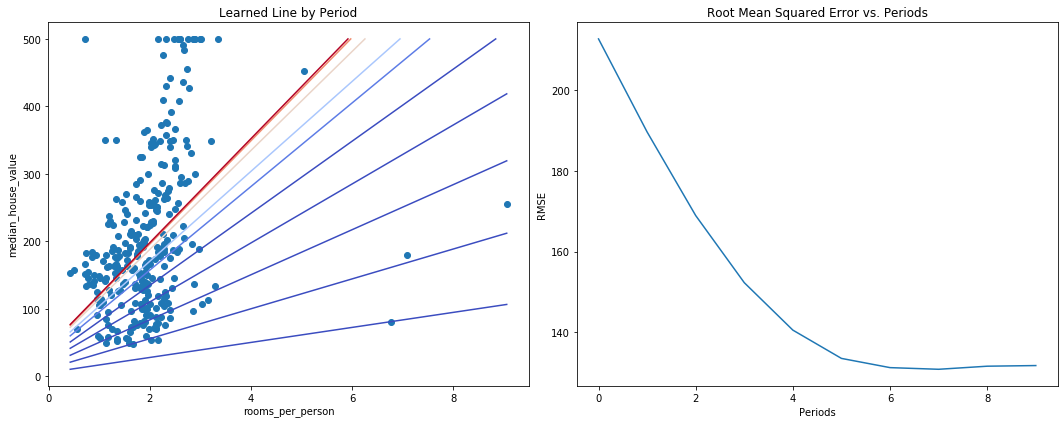

In [52]:
cal_housing['rooms_per_person'] = (cal_housing['total_rooms']/ cal_housing['population'])
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature='rooms_per_person'
)

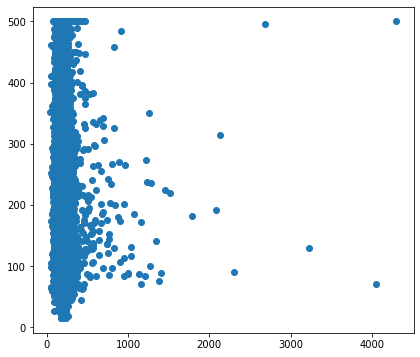

In [53]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(calibration_data["predictions"], calibration_data['targets'])

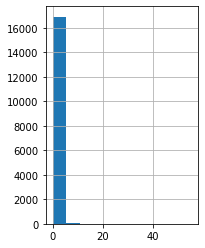

In [54]:
plt.subplot(1,2,2)
_ = cal_housing['rooms_per_person'].hist()

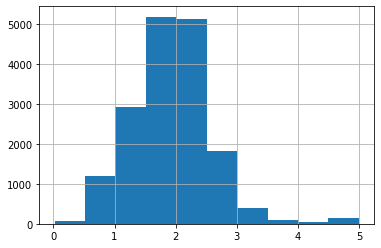

In [55]:
cal_housing['rooms_per_person'] = (cal_housing['rooms_per_person']).apply(lambda x:min(x,5))
_= cal_housing['rooms_per_person'].hist()

Training model...
RSME on training data:
  period 00 : 212.82
  period 01 : 189.05
  period 02 : 166.89
  period 03 : 147.20
  period 04 : 131.29
  period 05 : 120.79
  period 06 : 113.86
  period 07 : 110.19
  period 08 : 109.14
  period 09 : 107.97
Model training finished.


predictions       targets
count  17000.000000  17000.000000
mean     199.391235    207.300912
std       52.494144    115.983764
min       45.457176     14.999000
25%      165.867027    119.400000
50%      199.437027    180.400000
75%      227.983902    265.000000
max      444.335175    500.001000

Final RMSE (on training data): 107.97


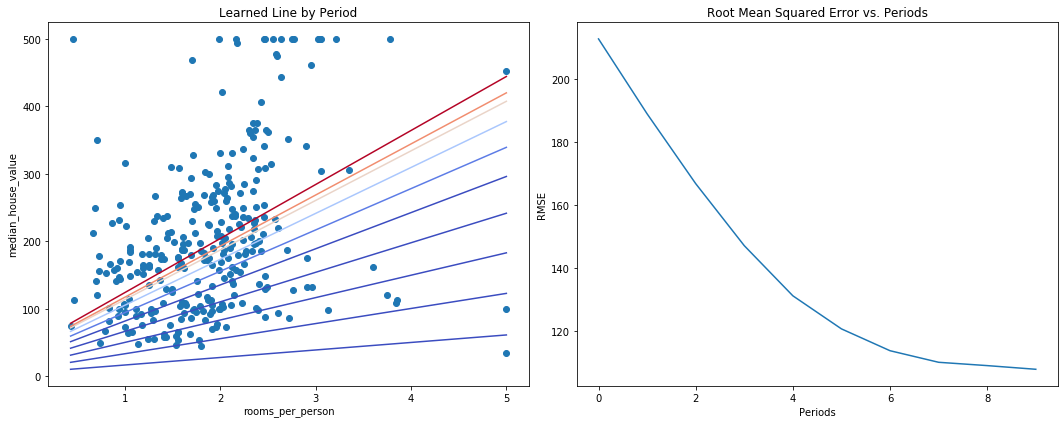

In [56]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature='rooms_per_person'
)

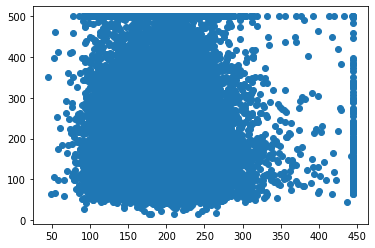

In [57]:
_ = plt.scatter(calibration_data['predictions'], calibration_data['targets'])